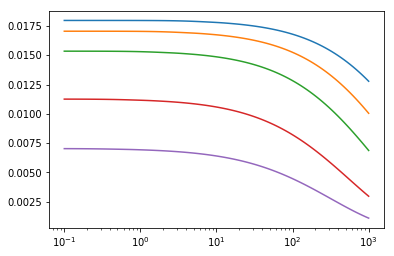

In [1]:
from clustering import *
theta_arr = np.logspace(-1,3,100)

for z in [0.05, 0.1, 0.2, 0.5, 1]:
    w_arr = wgI_zm_approx(z, theta_arr)
    plt.semilogx(theta_arr, w_arr)

In [1]:
from run_fit import * 

inst = 1
ifield = 8
im = 1
savedir = '/Users/ytcheng/Desktop/'
run_mcmc_fit(inst, ifield, im, savedir=savedir, nwalkers=5, steps=10)

MCMC fit 2 params for TM1 SWIRE 17 < m < 18


100%|██████████| 10/10 [04:08<00:00, 24.89s/it]
